In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=0ef8c70605da9f28be61776c896b8e8293412a3bcff00966b75a645716ce96bd
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
#Import statements
from pyspark.sql import SparkSession,Row
from pyspark.sql.functions import col, sum,when,exp
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from pyspark.ml.functions import vector_to_array
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
seed=99

In [5]:
#Create a Spark session
spark = SparkSession.builder.appName("SuperstoreAnalysis").getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")#Set legacy date parser due to issues with date format in new version

In [7]:
#Read CSV data
superstore_data_path = '/content/drive/My Drive/Colab Notebooks/BDA_Project/superstore_data.csv' #File path
superstore_df = spark.read.csv(superstore_data_path, header=True, inferSchema=True)
superstore_df.show()

+-----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
|   Id|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|
+-----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
| 1826|      1970|Graduation|      Divorced| 84835|      0|       0|  6/16/2014|      0|     189|      104|            379|            111|             189|         2

### Data Preprocessing

In [8]:
#Check the schema
superstore_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- Response: integer (nullable = true)
 |-- Complain: integer (nullable = true)



In [9]:
#Convert the two date fields to date format and check schema again
superstore_df = superstore_df.withColumn('Year_Birth', F.to_date(superstore_df['Year_Birth']))
superstore_df = superstore_df.withColumn('Dt_Customer', F.to_date(superstore_df['Dt_Customer'], 'MM/dd/yyyy'))
superstore_df.printSchema()
superstore_df.show()

root
 |-- Id: integer (nullable = true)
 |-- Year_Birth: date (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: date (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- Response: integer (nullable = true)
 |-- Complain: integer (nullable = true)

+-----+----------+--------

In [10]:
#Checking for missing values

# Count the number of null values in each column
null_counts = superstore_df.select(
    *[sum(col(c).isNull().cast("int")).alias(c) for c in superstore_df.columns]
)
null_counts.show()

+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
| Id|Year_Birth|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|
+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
|  0|         0|        0|             0|    24|      0|       0|          0|      0|       0|        0|              0|              0|               0|           0|         

From the above output we can see that only income has 24 missing values. We can impute these missing values using median of income for their respective education level

In [11]:
#Fill missing income values based on median income for their respective education level

#Compute the median income by education level
education_window = Window().partitionBy('Education')
superstore_df = superstore_df.withColumn('MedianIncome', F.expr('percentile_approx(Income, 0.5)').over(education_window))

# Update missing income values
superstore_df = superstore_df.withColumn('Income', F.when(superstore_df['Income'].isNull(), superstore_df['MedianIncome']).otherwise(superstore_df['Income']))

# Drop the temporary column used for computation
superstore_df = superstore_df.drop('MedianIncome')

# Show the updated DataFrame
superstore_df.show()

+-----+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
|   Id|Year_Birth|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|
+-----+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
| 4073|1954-01-01| 2n Cycle|       Married| 63564|      0|       0| 2014-01-29|      0|     769|       80|            252|             15|              34|          65| 

In [12]:
#Explore the two categorical variables Marital_Status and Education level
superstore_df.groupBy('Marital_Status').count().show()
superstore_df.groupBy('Education').count().show()

+--------------+-----+
|Marital_Status|count|
+--------------+-----+
|          YOLO|    2|
|      Together|  580|
|       Married|  864|
|        Absurd|    2|
|         Widow|   77|
|      Divorced|  232|
|         Alone|    3|
|        Single|  480|
+--------------+-----+

+----------+-----+
| Education|count|
+----------+-----+
|  2n Cycle|  203|
|       PhD|  486|
|    Master|  370|
|Graduation| 1127|
|     Basic|   54|
+----------+-----+



We can see two categories which dont make sense in Maritial Status - Yolo and Absurd. Since these contain a total of only 4 rows we can go ahead and drop them. Also we can combine the category Alone with single

In [13]:
#Drop rows where 'Marital_Status' is 'YOLO' or 'Absurd'
superstore_df = superstore_df.filter(~superstore_df['Marital_Status'].isin(['YOLO', 'Absurd']))
#Convert 'Alone' to 'Single'
superstore_df = superstore_df.withColumn('Marital_Status', F.when(superstore_df['Marital_Status'] == 'Alone', 'Single').otherwise(superstore_df['Marital_Status']))
superstore_df.groupBy('Marital_Status').count().show()

+--------------+-----+
|Marital_Status|count|
+--------------+-----+
|      Together|  580|
|       Married|  864|
|         Widow|   77|
|      Divorced|  232|
|        Single|  483|
+--------------+-----+



The two date columns indicate the customers date of birth and when the customer became a member of the store. We can convert this to age and years a customer has been a memeber by subtracting the current data from the respective dates. Since the exact date the data was collected is not mentioned, looking at the dates in the data we can assume this data was collected around 2015 and we will use that as the curent date.

In [14]:
#Get the age and number of days the custoemr has been a memeber

current_date = F.to_date(F.lit('1/1/2015'), 'MM/dd/yyyy')#Set current date to 2015

# Calculate the number of days the customer has been a memeber
superstore_df = superstore_df.withColumn('Customer_Days', F.datediff(current_date, 'Dt_Customer'))

# Calculate the age of the customer
superstore_df=superstore_df.withColumn('Customer_Age', F.year(current_date) - F.year('Year_Birth'))

superstore_df.show()

+-----+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+-------------+------------+
|   Id|Year_Birth|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|Customer_Days|Customer_Age|
+-----+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+-------------+------------+
| 4073|1954-01-01| 2n Cycle|       Married| 63564|      0|       0| 2014-01-29|      0| 

In [15]:
 #Drop the columns which are not required
 superstore_df = superstore_df.drop(*["Year_Birth", "Id", "Dt_Customer"])
 superstore_df.show()

+---------+--------------+------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+-------------+------------+
|Education|Marital_Status|Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|Customer_Days|Customer_Age|
+---------+--------------+------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+-------------+------------+
| 2n Cycle|       Married| 63564|      0|       0|      0|     769|       80|            252|             15|              34|          65|                1|             10|  

### EDA And Visualization

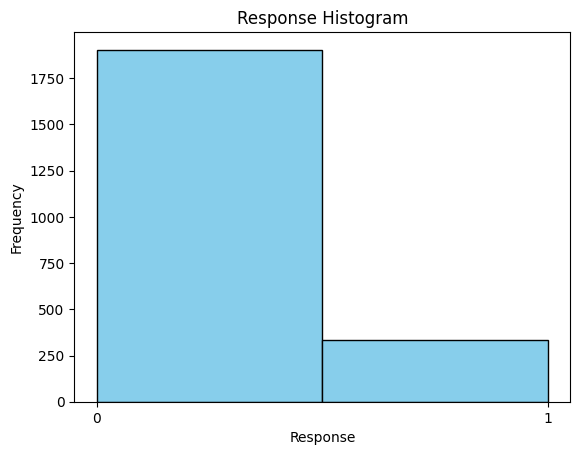

In [16]:
#Distribution of responsr

data = superstore_df.toPandas()
plt.hist(data['Response'], bins=2, edgecolor='k', color='skyblue')
plt.title("Response Histogram")
plt.xlabel("Response")
plt.ylabel("Frequency")
plt.xticks([0, 1])  # Set x-axis ticks to be 0 and 1
plt.show()


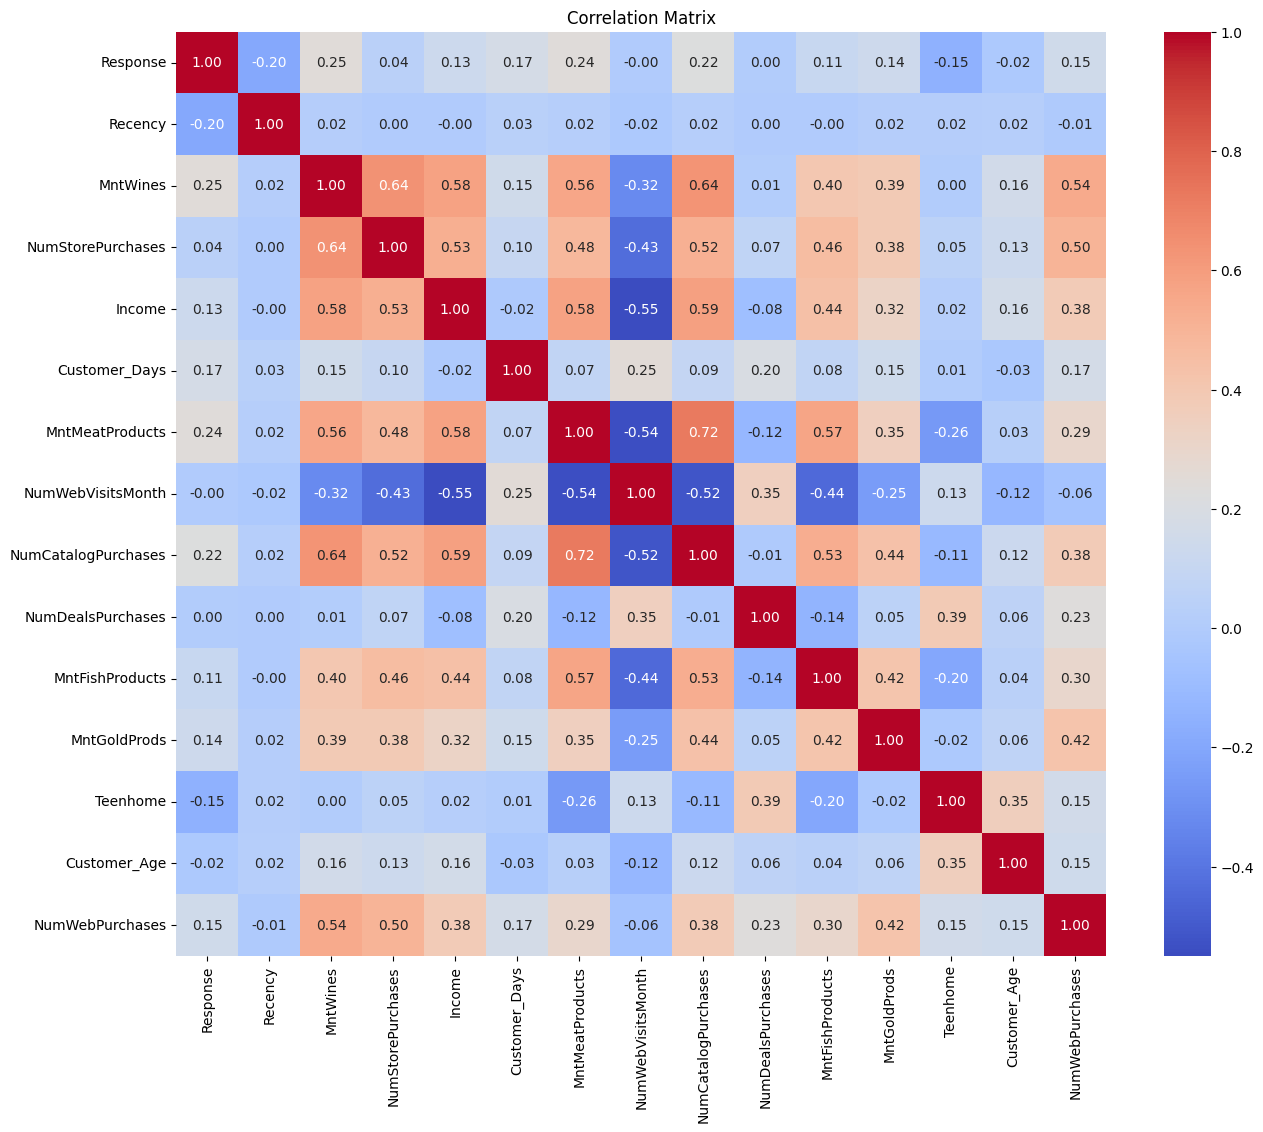

In [17]:
#Plot correlation matrix
data = superstore_df.toPandas()

correlation_matrix = data[["Response", "Recency", "MntWines", "NumStorePurchases","Income","Customer_Days",
                           "MntMeatProducts","NumWebVisitsMonth", "NumCatalogPurchases", "NumDealsPurchases",
                           "MntFishProducts","MntGoldProds", "Teenhome", "Customer_Age", "NumWebPurchases"]].corr()


plt.figure(figsize=(15, 12))


sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


The correlation matrix reveals insights into relationships between different variables. Notably, there is a positive correlation between "MntWines" (amount spent on wines) and both "Income" and "NumStorePurchases," suggesting that higher income levels and more store purchases are associated with increased spending on wines. The negative correlation between "Recency" and "Response" suggests that as the "Recency" of interactions increases (i.e., more time has passed since the last interaction), there is a tendency for a lower likelihood of positive responses to campaigns.

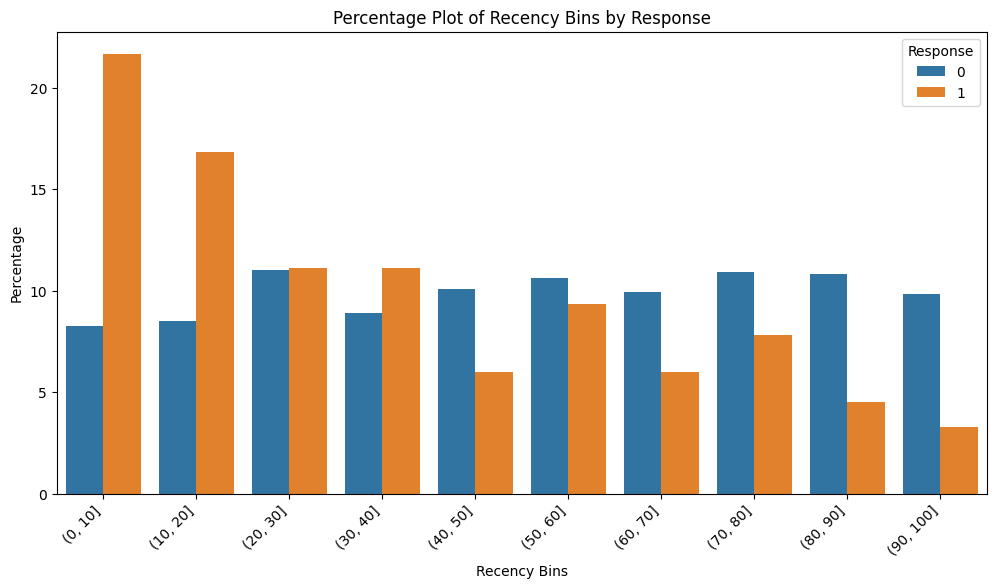

In [18]:
# Assuming superstore_df is your PySpark DataFrame
pandas_df = superstore_df.toPandas()

# Calculate the total count of each response category
total_counts = pandas_df['Response'].value_counts()

# Define bin edges based on unique values
bin_edges = range(0, max(pandas_df['Recency']) + 11, 10)

# Create a new column 'Recency_Bin' with bin labels
pandas_df['Recency_Bin'] = pd.cut(pandas_df['Recency'], bins=bin_edges, include_lowest=False, precision=0)

# Calculate the percentage of each response category within each bin
percentage_df = pandas_df.groupby(['Recency_Bin', 'Response']).size() / pandas_df.groupby('Response').size() * 100
percentage_df = percentage_df.reset_index(name='Percentage')

# Set the size of the figure for better readability
plt.figure(figsize=(12, 6))

# Create bar plot using Seaborn
sns.barplot(x='Recency_Bin', y='Percentage', hue='Response', data=percentage_df)
plt.xlabel('Recency Bins')
plt.ylabel('Percentage')
plt.title('Percentage Plot of Recency Bins by Response')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()


In the Recency vs. Response plot, it clearly indicates that the recency is inversely proportional to the percentage of people responding positively to the campaign. When the recency has a lower value between 0-10 the percentage of people responding positively is the maximum. Additionally, it is also noteworthy that in the bins with lower values for recency, the positive percenatge is higher than negative percentage.

Text(0.5, 1.0, 'Average Income by Response')

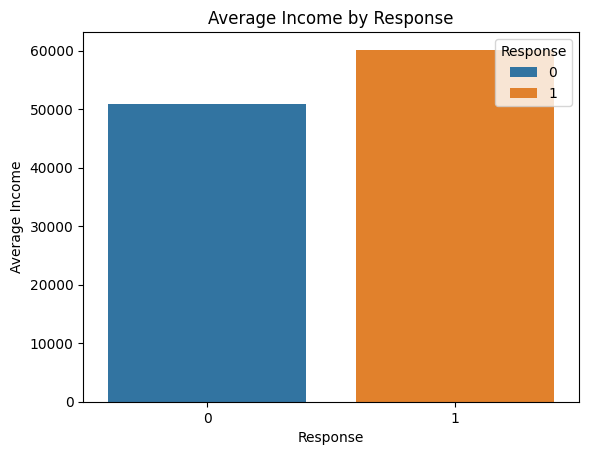

In [19]:
#Average Income according to response

df = superstore_df.toPandas()
df=df.groupby(["Response"])["Income"].mean().reset_index()
sns.barplot(x='Response', y='Income', hue='Response', data=df)
plt.xlabel('Response')
plt.ylabel('Average Income')
plt.title('Average Income by Response')



Text(0.5, 1.0, 'Average MntWines by Response')

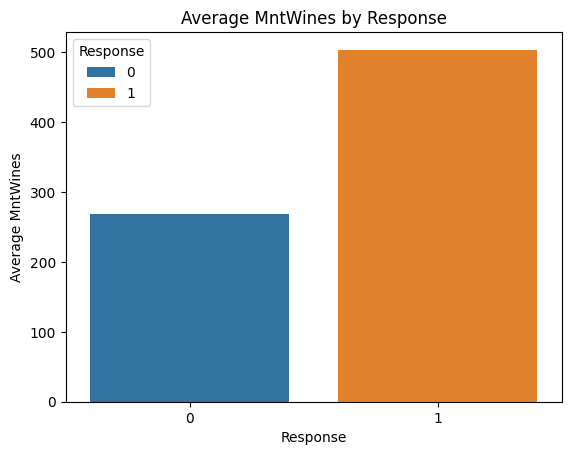

In [20]:
#Average amount spend on alchohol me according to response
df = superstore_df.toPandas()
df=df.groupby(["Response"])["MntWines"].mean().reset_index()
sns.barplot(x='Response', y='MntWines', hue='Response', data=df)
plt.xlabel('Response')
plt.ylabel('Average MntWines')
plt.title('Average MntWines by Response')


Text(0.5, 1.0, 'Average Income by Education')

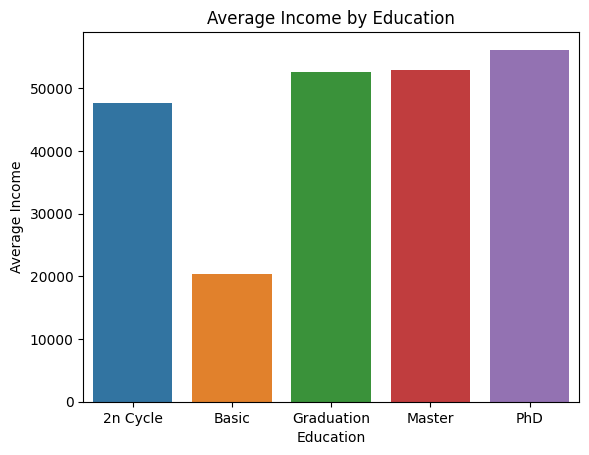

In [21]:
#Average Income according to Eeducation level

df = superstore_df.toPandas()
df=df.groupby(["Education"])["Income"].mean().reset_index()
sns.barplot(x='Education', y='Income', hue='Education', data=df)
plt.xlabel('Education')
plt.ylabel('Average Income')
plt.title('Average Income by Education')